In [1]:
!pip install gdown  # Ensure gdown is installed

In [2]:
import gdown

# Replace FILE_ID with your actual file ID
file_id = "1d6G2RkXVNnMBJTO-QWCx6QZ2bMElMqgu"
output_file = "Chest_XRay_Datasets.zip"

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1d6G2RkXVNnMBJTO-QWCx6QZ2bMElMqgu
From (redirected): https://drive.google.com/uc?id=1d6G2RkXVNnMBJTO-QWCx6QZ2bMElMqgu&confirm=t&uuid=67887602-3791-4416-8111-9a3ff169c9aa
To: /content/Chest_XRay_Datasets.zip
100%|██████████| 1.01G/1.01G [00:11<00:00, 88.7MB/s]


'Chest_XRay_Datasets.zip'

In [3]:
import zipfile
z = zipfile.ZipFile('/content/Chest_XRay_Datasets.zip')
z.extractall()

# **Import Libraries**

In [4]:
import os
import torch
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import datasets
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image, ImageOps
from torch.utils.data import DataLoader, random_split

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# **Plot Bar Graph**

[1594, 1470]
['PNEUMONIA', 'NORMAL']


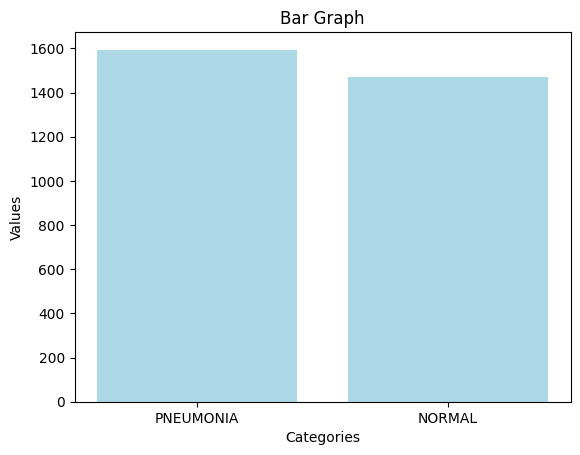

In [5]:
images_dir = "Chest_XRay_Datasets/train"
images_dir_folders = os.listdir(images_dir)

no_img_classes = []

for images_dir_folder in images_dir_folders:
  no_images = os.listdir(os.path.join(images_dir,images_dir_folder))
  no_img_classes.append(len(no_images))

print(no_img_classes)
print(images_dir_folders)


plt.bar(images_dir_folders, no_img_classes, color='lightblue')
plt.xlabel("Categories")
plt.ylabel("Values")
plt.title("Bar Graph")

plt.show()

# **Display the images**

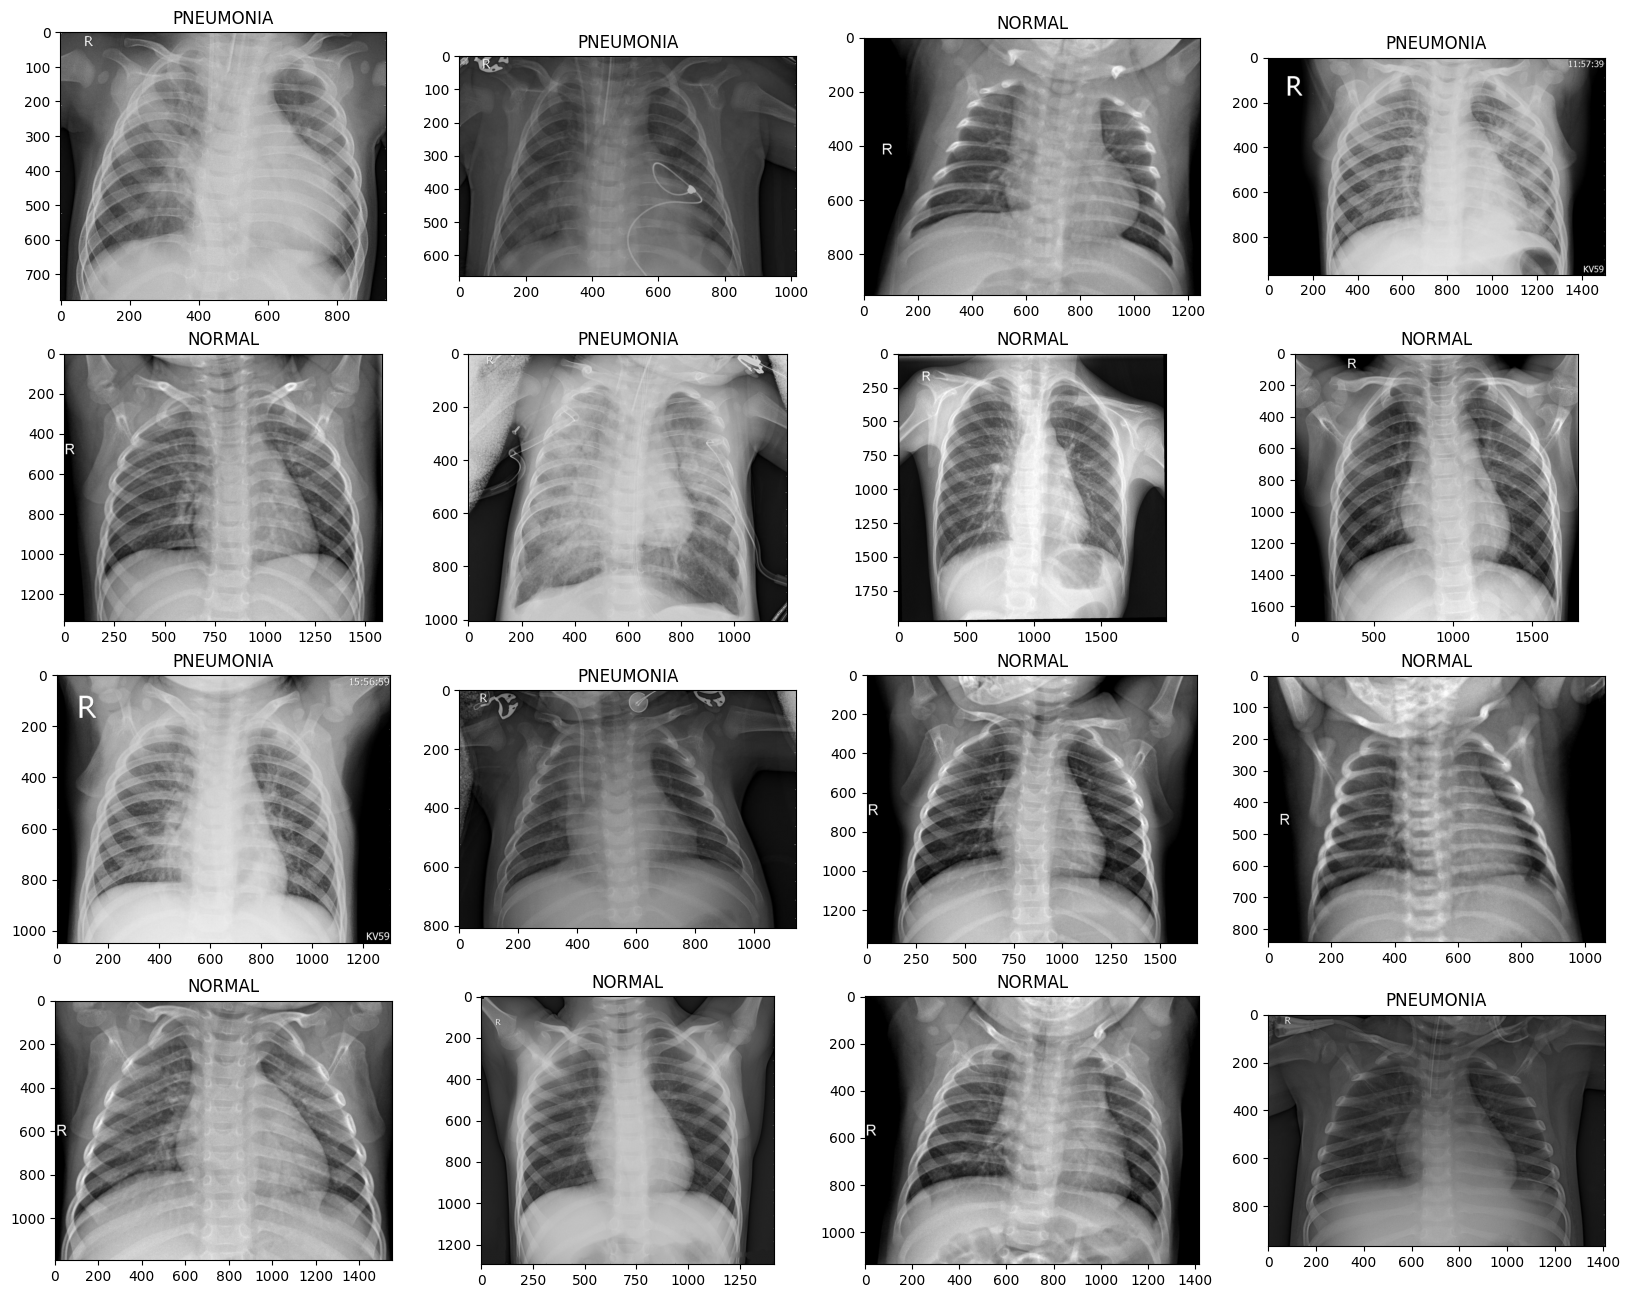

In [6]:
images_dir = "Chest_XRay_Datasets/train"
images_dir_folders = os.listdir(images_dir)

fig,ax = plt.subplots(4,4,figsize=(20,16))
ax = ax.ravel()

for i in range(16):
    images_folder = random.choice(images_dir_folders)
    images_files = os.listdir(os.path.join(images_dir,images_folder))
    img_path = os.path.join(images_dir,images_folder,random.choice(images_files))

    img = Image.open(img_path)
    cls_name = images_folder

    ax[i].imshow(img,cmap='gray')
    ax[i].set_title(cls_name)

plt.show()

# **Transfroms**

In [7]:
transformation = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure it's grayscale
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop & resize
    transforms.RandomHorizontalFlip(p=0.5),  # Flip with 50% probability
    transforms.RandomRotation(15),  # Rotate up to ±15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10),  # Small shifts & shearing
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Add slight blur for robustness
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])


# **Create train oject**

In [8]:
# Load dataset
dataset = datasets.ImageFolder(root="Chest_XRay_Datasets/train", transform=transformation)
class_to_idx = dataset.class_to_idx

# Split dataset (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
traindata = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valdata = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


# Print class index mapping
print(class_to_idx)
print(len(train_dataset))
print(len(traindata))

Training samples: 2451
Validation samples: 613
{'NORMAL': 0, 'PNEUMONIA': 1}
2451
77


# **Plot the images**

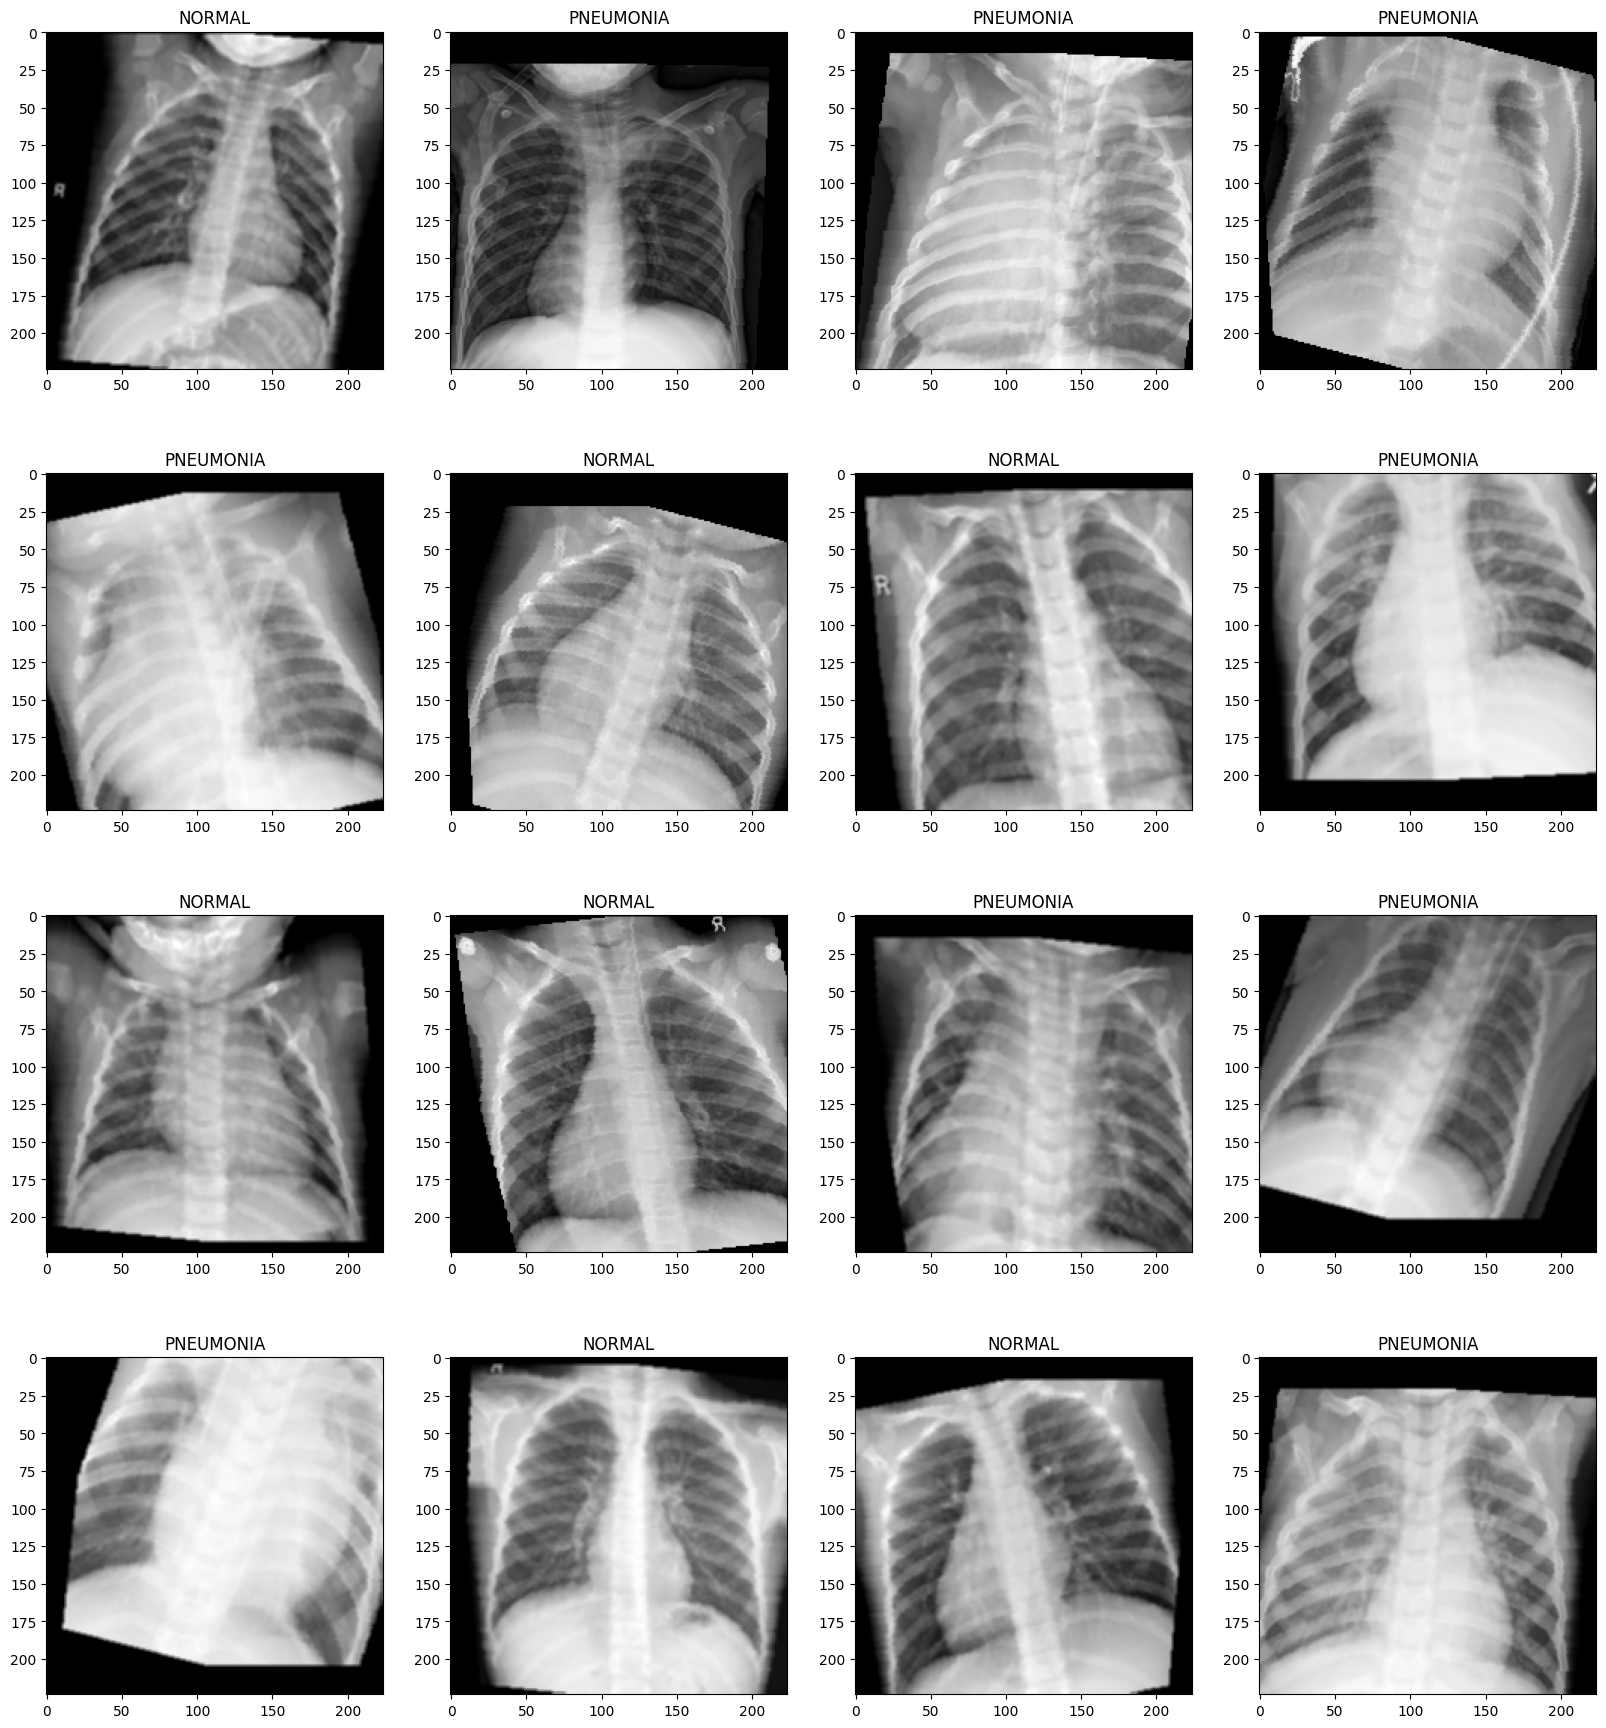

In [9]:
samples,labels = next(iter(traindata))

fig, axes = plt.subplots(4,4,figsize=(20,22))
axes = axes.ravel()

class_names = {0:'NORMAL', 1:'PNEUMONIA'}

for i in range(16):
    axes[i].imshow(samples[i].permute(1,2,0),cmap='gray')  ## (C,H,W) to (H,W,C)
    # print(labels[i])
    axes[i].set_title(class_names[labels[i].item()])


# **Create the CNN model**

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.batch1 = nn.BatchNorm2d(num_features=16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.batch2 = nn.BatchNorm2d(num_features=32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.batch3 = nn.BatchNorm2d(num_features=64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.batch4 = nn.BatchNorm2d(num_features=128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3)
        self.batch5 = nn.BatchNorm2d(num_features=512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=5*5*512, out_features=1024)
        self.fc1_batch = nn.BatchNorm1d(num_features=1024)

        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc2_batch = nn.BatchNorm1d(num_features=256)

        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.fc3_batch = nn.BatchNorm1d(num_features=128)

        self.fc4 = nn.Linear(in_features=128, out_features=3)

        self.softmax = nn.Softmax(dim=1)


    def forward(self,x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.batch3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.batch4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.batch5(x)
        x = F.relu(x)
        x = self.pool5(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.fc1_batch(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = self.fc2_batch(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = self.fc3_batch(x)
        x = F.relu(x)

        x = self.fc4(x)
        x = self.softmax(x)

        return x

model = CNN().to(device)

# **Get the model summary**

In [11]:
from torchsummary import summary
summary(model, (1,224,224)) # (C,H,W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             160
       BatchNorm2d-2         [-1, 16, 222, 222]              32
         MaxPool2d-3         [-1, 16, 111, 111]               0
            Conv2d-4         [-1, 32, 109, 109]           4,640
       BatchNorm2d-5         [-1, 32, 109, 109]              64
         MaxPool2d-6           [-1, 32, 54, 54]               0
            Conv2d-7           [-1, 64, 52, 52]          18,496
       BatchNorm2d-8           [-1, 64, 52, 52]             128
         MaxPool2d-9           [-1, 64, 26, 26]               0
           Conv2d-10          [-1, 128, 24, 24]          73,856
      BatchNorm2d-11          [-1, 128, 24, 24]             256
        MaxPool2d-12          [-1, 128, 12, 12]               0
           Conv2d-13          [-1, 512, 10, 10]         590,336
      BatchNorm2d-14          [-1, 512,

# **Define optimizers**

In [12]:
criterian = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 30

# **Define model training**

In [ ]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []


best_val_loss = float('inf')  # Initialize with a high value

# Directory to save models
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

for epoch in range(epochs):
    model.train()
    correct = 0
    train_running_loss = 0.0

    for data,labels in traindata:
        data,labels = data.to(device), labels.to(device)
        optimizer.zero_grad() ## convert the gradient values into zero for each batch
        output = model(data)
        loss = criterian(output, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()

        _,pred = torch.max(output,1)

        correct += (pred == labels).sum().item()

    epoch_train_loss = train_running_loss / len(traindata)
    epoch_train_accuracy = (100 * correct) / len(train_dataset)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)

    print(f'Epoch: {epoch+1} Training Loss: {epoch_train_loss} Training Accuracy: {epoch_train_accuracy}')

    with torch.no_grad():
        model.eval()
        correct = 0
        val_running_loss = 0.0
        for val_data, val_labels in valdata:
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            val_output = model(val_data)
            val_loss_value = criterian(val_output, val_labels)

            val_running_loss += val_loss_value.item()
            _,val_pred = torch.max(val_output,1)
            correct += (val_pred == val_labels).sum().item()

        epoch_val_loss = val_running_loss / len(valdata)
        epoch_val_accuracy = (100 * correct) / len(val_dataset)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)

        print(f'Epoch: {epoch+1} Validation Loss: {epoch_val_loss} Validation Accuracy: {epoch_val_accuracy}')


        # **ModelCheckpoint: Save best model based on validation loss**
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            checkpoint_path = os.path.join(checkpoint_dir, f"best_model.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"🔥 Best model saved at {checkpoint_path} with Validation Loss: {epoch_val_loss:.4f}")

    # Update learning rate
    scheduler.step()
    print(f"🔄 Updated Learning Rate: {scheduler.get_last_lr()[0]:.6f}\n")

    print("\n")

# **Plot the graph**

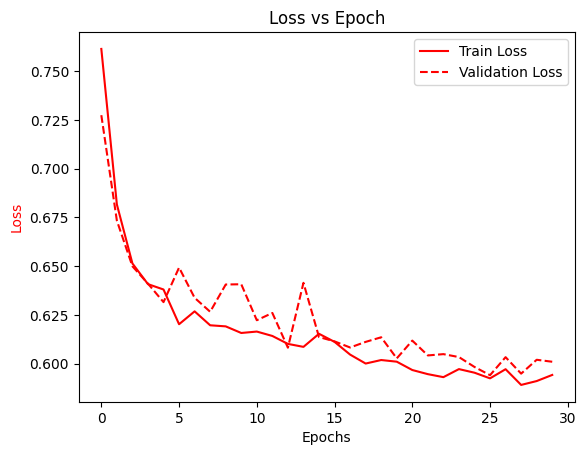

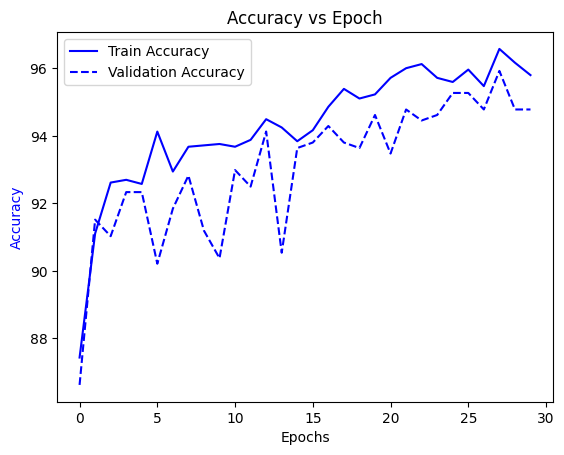

In [ ]:
epoch_log = [*range(epochs)]

fig,ax1 = plt.subplots()
ax1.plot(epoch_log,train_loss,'r-',label = 'Train Loss')
ax1.plot(epoch_log,val_loss,'r--',label = 'Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss',color='r')
ax1.set_title('Loss vs Epoch')
ax1.legend()
plt.show()

fig,ax2 = plt.subplots()
ax2.plot(epoch_log,train_accuracy,'b-',label = 'Train Accuracy')
ax2.plot(epoch_log,val_accuracy,'b--',label = 'Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy',color='b')
ax2.set_title('Accuracy vs Epoch')
ax2.legend()
plt.show()

# **Load the model**

In [ ]:
# Initialize the model before loading weights
model = CNN()  # Ensure MyModel is defined
model.load_state_dict(torch.load("checkpoints/best_model.pth"))  # Load state_dict into the model
model.to(device)  # Move model to GPU or CPU
model.eval()  # Set to evaluation mode


<ipython-input-15-64ba658cf935>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/best_model.pth"))  # Load state_dict into the 

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 512, kernel_siz

# **Plot the images**

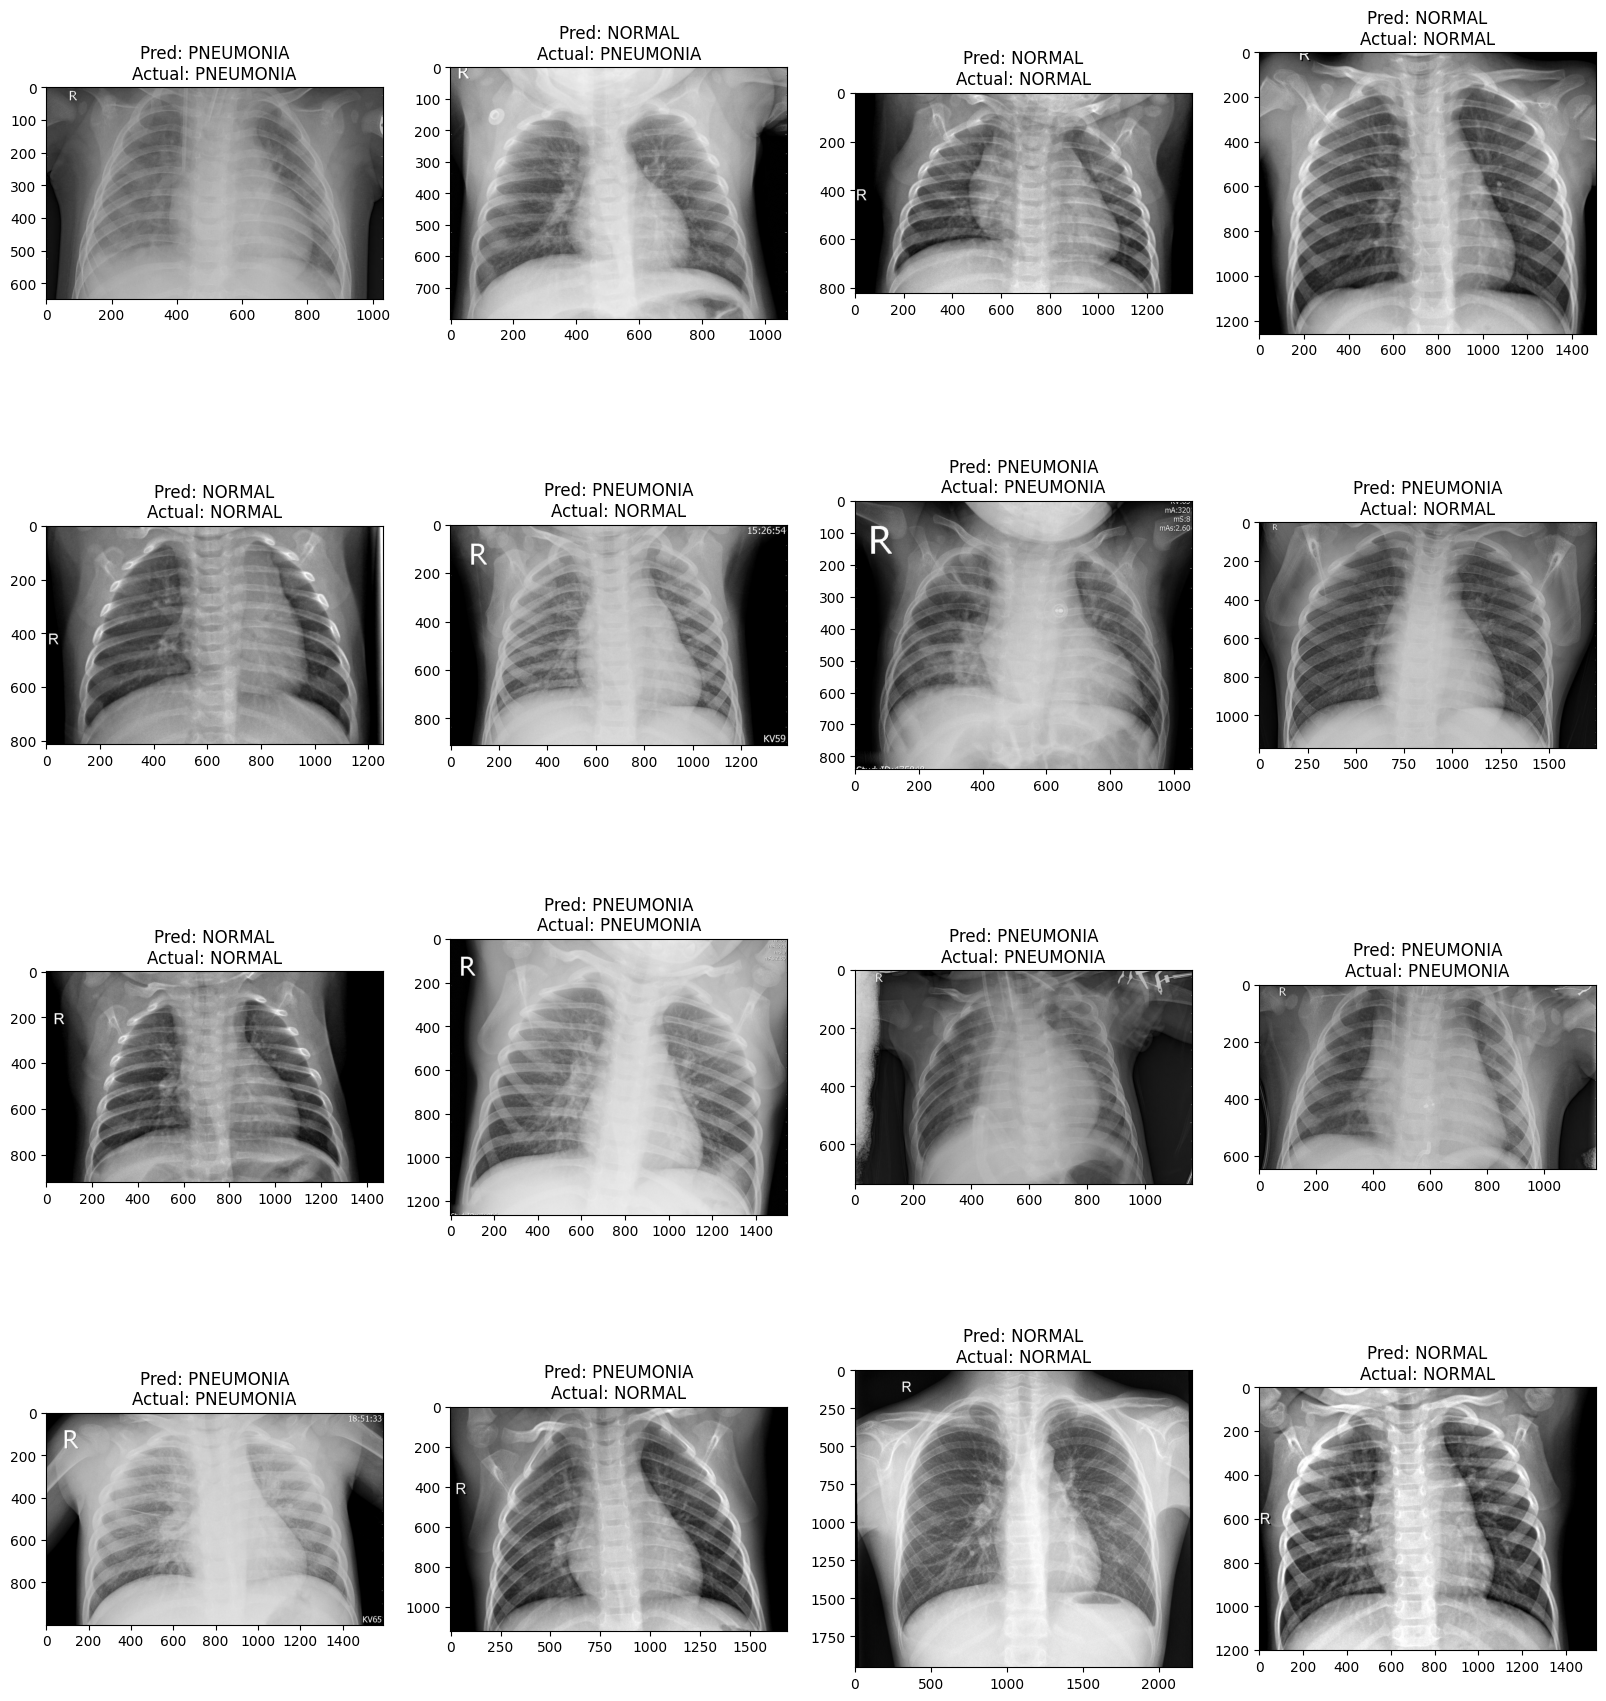

In [ ]:
import random

test_dir = "Chest_XRay_Datasets/test"
test_dir_folders = os.listdir(test_dir)

images = []
def preprocessing(image):
    img = transformation(image) ##  (c,h,w) required == (b,c,h,w) ==> (1,3,60,60)
    img = img.unsqueeze(0)
    return img

fig, axes = plt.subplots(4,4,figsize=(20,22))
axes = axes.ravel()

class_names = {0:'NORMAL', 1:'PNEUMONIA'}

for i in range(16):
    img_folder = random.choice(test_dir_folders)
    img_filenames = os.listdir(os.path.join(test_dir,img_folder))
    img_path = os.path.join(test_dir, img_folder, random.choice(img_filenames))

    image = Image.open(img_path)
    preprocessed_img = ImageOps.grayscale(image)
    preprocessed_img = preprocessing(preprocessed_img)
    preprocessed_img = preprocessed_img.to(device)

    output = model(preprocessed_img)
    pred = torch.argmax(output).item()
    label = class_names[pred]

    axes[i].imshow(image,cmap='gray')
    axes[i].set_title(f'Pred: {label}\nActual: {img_folder}')

plt.show()
